In [1]:
import matplotlib.pyplot as plt
import numpy as np

from utils import *

# {{ exercise }} Introduction to PCA

In this exercise you will create a basic PCA implementation that you will use for the next exercise.


## Implementing PCA

Your first task is to implement the PCA method as well as functions for
transforming to and from the space defined by the principal components.
But first, a quick recap of the terminology to minimize confusion.

Principal component analysis is about finding a linear transformation
that reduces the number of dimensions used to represent samples while
destroying as little of the variation as possible. PCA is defined by
$\Phi_{:k}$, an $M\times k$ matrix representing a linear transformation from
vectors in $M$-dimensional data space to $k$-dimensional latent space. We have the
following transformations

$$ 
b = \Phi_{:k}^\top x, 
$$

$$
x + \epsilon = \Phi_{:k} b,
$$

where
$x\in\mathbb{R}^M$ is the input vector and $b\in\mathbb{R}^K$ is the
embedded vector. As shown in the second equation, it is possible to reconstruct $x$ with some amount of error $\epsilon$. To find $\Phi$, we use the _eigenvectors_ of the covariance matrix of our data matrix $W$ where each row $i$ is a sample $x_i \in \mathbb{R}^M$. The eigenvectors are sorted by their associated eigenvalues which represent the variance of each dimension in latent space. Selecting the $k$ first columns (we use the notation $\Phi_{:k}$) results in a transformation that reduces the dimensionality of the latent space to $k$ dimensions. 


1.  {{ task-code }} **Implement PCA:** Create a function that calculates and returns the
    principle components of the shapes dataset. Use the method described
    above where the eigenvectors of the covariance matrix is used.
    **Make sure to center the samples (subtract the mean before
    calculating the covariance matrix)**.

2.  {{ task-code }} **Implement transformations:** Create two functions, one for
    transforming from feature space to principal component space
    (eqaution {eq}`trans`) and one for transforming from principal
    component space to feature space
    (equation {eq}`inv`). You have to subtract the mean, $\mu$, vector when
    transforming to the principal component space and add it again when
    transforming back to feature space. You may use the following
    modified equations for reference:

$$
b = \Phi_{:k}^\top(x-\mu)
$$  

$$
x = \Phi_{:k} b + \mu
$$

```{tip}
The reading material for the PCA lecture contains an excellent [tutorial](https://sebastianraschka.com/Articles/2014_pca_step_by_step.html) on how this can be done, but remember that copying is not allowed!!
```

```{tip}
Some of the later tasks will be easier if you return all 146 principle components. You can then create another function for extracting $n$ components to generate $\Phi$.
```


In [289]:
# Write your implementation here.

def get_principle_components(shapes):
    # # Step 2: Calculating meanvector
    meanVector = np.mean(shapes.T, axis=1)
    
    # Centering samples
    centeredShapes = shapes - meanVector

    # Step 3.b: Computing the covariance matrix
    covarianceMatrix = np.cov(centeredShapes.T)

    # Step 4: Computing eigenvectors and eigenvalues
    eigenValues, eigenVectors = np.linalg.eig(covarianceMatrix)

    # Step 5.1
    # Sort eigenvectors by decreasing eigenvalues
    eigenPairs = [(np.abs(eigenValues[i]), eigenVectors[:,i]) for i in range(len(eigenValues))]
    eigenPairs.sort(key=lambda x: x[0], reverse=True)

    # Step 5.2
    # Creating eigenvector matrix W but with the same k
    matrixW = eigenPairs[0][1].reshape(len(shapes[0]), 1)
    for d in range(1, len(shapes)):
        matrixW = np.hstack((matrixW, eigenPairs[d][1].reshape(len(shapes[0]), 1)))
    
    # Returning the W matrix, eigenValues (I think that was what was meant by val?), and the mean vector (my)
    return matrixW, eigenValues, meanVector



In [295]:
# Step 6: Transforming the samples onto the new subspace (wk is expected to be reduced to k dimensions)
# equation trans
def transform(x, wk, u):
    b = np.dot(np.transpose(wk), np.transpose(x - u))
    return b

# equation inv
def transformBack(b, wk, u):
    x = np.dot(wk, np.transpose(b))
    for i in range(len(x)):
        x[i] = x[i] + u[i]
    return x

In [296]:
# Load data
path = './db'
shapes, images = face_shape_data(path)

#Your implementation, uncomment below when the pca and tranformation is working.

n_components = 146
comp, val, mu = get_principle_components(shapes)

used = comp[:, :n_components]
print("Original shapes:\n", shapes)

transformed = transform(shapes, used, mu)
print("\nTransformed shapes:\n", transformed)

transformedBack = transformBack(transformed, used, mu)
print("\nTransformed back to original shapes:\n", transformedBack)

120
Original shapes:
 [[-0.12118084 -0.10599773 -0.09972317 ...  0.09159876  0.13804808
   0.0317374 ]
 [-0.12106093 -0.11516926 -0.10307789 ...  0.09591061  0.13727475
   0.04046178]
 [-0.1237347  -0.10303802 -0.10523646 ...  0.08152419  0.13704319
   0.01980427]
 ...
 [-0.12568886 -0.11200123 -0.11172953 ...  0.12620653  0.15206109
   0.07766519]
 [-0.12247754 -0.1148791  -0.1072442  ...  0.12278225  0.14627607
   0.07366567]
 [-0.12308832 -0.11129153 -0.10852273 ...  0.1356115   0.14591611
   0.08376085]]

Transformed shapes:
 [[-3.43241375e-02+0.j -3.77402183e-02+0.j -5.16889066e-02+0.j ...
   5.38828509e-02+0.j  2.87240598e-02+0.j  5.37804943e-02+0.j]
 [ 2.94763854e-02+0.j  2.36983437e-02+0.j  3.91355582e-02+0.j ...
  -4.18755334e-02+0.j -3.36469417e-02+0.j -5.26907749e-02+0.j]
 [-3.46530642e-03+0.j  2.00605508e-02+0.j -5.62181824e-03+0.j ...
   3.16328035e-02+0.j  3.75539257e-02+0.j  3.34106396e-02+0.j]
 ...
 [-2.73525003e-06+0.j -3.00194403e-05+0.j  3.06318580e-05+0.j ...
   6.9

## Evaluating precision

As described above, using PCA to transform a sample $x$ to a principal
component space and back again likely results in an error $\epsilon$, called the _reconstruction error_. In this task you will implement a
method for calculating this error and use it to test the effect of
increasing or decreasing the number of principal components used.

When solving regression problems, the error is typically measured as the
average distance error, otherwise known as root mean square error
(RMSE). This is also used when calculating the construction error. For
reference, the RMSE is

$$RMSE(x, \widetilde{x}) = \sqrt{\frac{1}{N}\sum_i (x_i-\widetilde{x}_i)^2},$$

where $x$, $\widetilde{x}$ are the original and transformed samples
respectively and $N$ is the total number of samples $x_i$.

Another method for evaluating PCA models is to look at the eigenvalues,
where eigenvalue $i$ is denoted $\lambda^{(i)}$. The eigenvalues explain
the variance of each dimension when that data has been transformed by
PCA. The sum of all eigenvalues $\lambda^{(1)}+\dots+\lambda^{(n)}$ is
equal to the total variance of the data. By comparing all the
eigenvalues we can calculate:

(1) **Proportional variance:** What proportion of the total variance is
explained by a single component. The following formula can be used

$$\frac{\lambda^{(i)}}{\lambda^{(1)} + \dots + \lambda^{(n)}}$$

(2) **Cumulative proportional variance:** What cumulative proportion of
the total variance is explained by the first $k$ components.

$$\frac{\lambda^{(1)} + \dots + \lambda^{(k)}}{\lambda^{(1)} + \dots + \lambda^{(n)}}$$


1.  **{{ task-code }} Calculate reconstruction error:** Implement a function in your
    script that calculates the reconstruction error given a dataset $X$,
    principle components $\Phi$, and a mean vector $\mu$.

2.  **{{ task-code }} Plot reconstruction error:** When constructing $\Phi$ you may use a single principal component or all of them. Plot the reconstruction error of $\Phi$ for all possible numbers of principle components. An example is shown in {numref}`fig:plot_var`.

3.  **{{ task-code }} Calculate variance:** Create functions that calculate the
    _proportional_ and _cumulative proportional_ variance.

4.  **{{ task-code }} Plot variance metrics:** Plot both the proportional and cumulative
    proportional variance in a single plot. An example is shown in
    {numref}`fig:plot_var`.


```{figure} ./img/plot_var.png
---
name: fig:plot_var
width: 400px
---
The expected result of the cumulative and individual variance
proportion.
```

(120, 146)
(120, 146)
[[-0.12118084 -0.10599773 -0.09972317 ...  0.09159876  0.13804808
   0.0317374 ]
 [-0.12106093 -0.11516926 -0.10307789 ...  0.09591061  0.13727475
   0.04046178]
 [-0.1237347  -0.10303802 -0.10523646 ...  0.08152419  0.13704319
   0.01980427]
 ...
 [-0.12568886 -0.11200123 -0.11172953 ...  0.12620653  0.15206109
   0.07766519]
 [-0.12247754 -0.1148791  -0.1072442  ...  0.12278225  0.14627607
   0.07366567]
 [-0.12308832 -0.11129153 -0.10852273 ...  0.1356115   0.14591611
   0.08376085]]
[[-0.17745189+0.j -0.08547384+0.j -0.11150474+0.j ... -0.12338898+0.j
  -0.12330969+0.j -0.1233574 +0.j]
 [-0.07250282+0.j -0.11104845+0.j -0.10797472+0.j ... -0.10838354+0.j
  -0.10830374+0.j -0.10821668+0.j]
 [-0.1722147 +0.j -0.13273902+0.j -0.15213298+0.j ... -0.10734676+0.j
  -0.10727025+0.j -0.10727042+0.j]
 ...
 [ 0.08260158+0.j  0.14551112+0.j  0.10906991+0.j ...  0.10261541+0.j
   0.1025936 +0.j  0.10262503+0.j]
 [ 0.1003461 +0.j  0.23176967+0.j  0.12577383+0.j ...  0.1436

c:\Users\mikke\anaconda3\envs\iaml\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


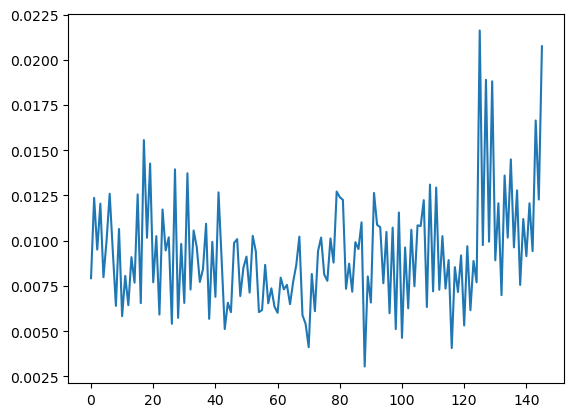

In [321]:
# Write your implementation here.
# 1 Calculate reconstruction error:
def reconstructionError(X, pc, u):
    transformed = transform(X, pc, u)
    transformedBack = transformBack(transformed, pc, u)
    sum = 0
    print(X.shape)
    print(transformedBack.T.shape)
    print(X)
    print(transformedBack)
    for i in range(len(X)):
        sum = sum + np.power((X[i] - transformedBack.T[i]), 2)
    return (np.sqrt((1/len(u)) * sum))

# 2 Plot reconstruction error:
#for i in range(1, len(shapes[0])):
comp, val, mu = get_principle_components(shapes)
used = comp[:, :146]
rcError = reconstructionError(shapes, used, mu)
plt.plot(rcError)

# 3 Calculate variance:
def proportionalVariance(eigenValues, index):
    return eigenValues[index] / np.sum(eigenValues)

def cumulativeProportionalVariance(eigenValues, k):
    return np.sum(eigenValues[:,k]) / np.sum(eigenValues)


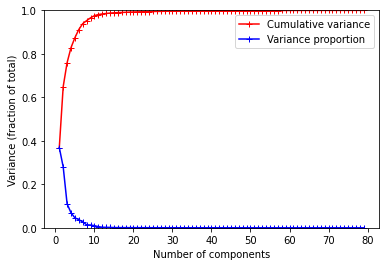

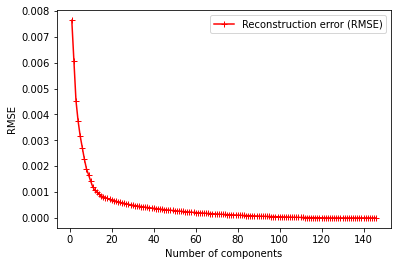

In [9]:
# Write your implementation here.
